### Imports

In [1]:
from matplotlib_venn import venn2 
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
from sklearn.metrics import silhouette_score
from sklearn.model_selection import RandomizedSearchCV
from tqdm import tqdm
from utils.utils import *

import hdbscan
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pandas as pd
import sys

%load_ext autotime

/home/ealvarez/miniconda3/envs/Conda_dgl_3.10/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/ealvarez/miniconda3/envs/Conda_dgl_3.10/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/ealvarez/miniconda3/envs/Conda_dgl_3.10/li

time: 159 µs (started: 2023-07-11 14:15:30 -05:00)


### Parameters

In [45]:
import json
  
# Opening JSON file
file = open("parameters.json")
params = json.load(file)

exp = params["exp"]
print("Exp:\t\t", exp)

methods = ["greedy", "dgi", "vgae"]
print("Methods:\t", methods)

dimension = params["dimension"]
print("Dimension:\t", dimension)

groups_id = params["groups_id"]
print("Groups id:\t", groups_id)

subgroups_id = params["subgroups_id"]
print("Subgroups id:\t", subgroups_id)

options = ["", "str", "dyn"]
print("Options:\t", options)

Exp:		 exp1
Methods:	 ['greedy', 'dgi', 'vgae']
Dimension:	 3
Groups id:	 ['WT', 'zwf1^', 'pck1^']
Subgroups id:	 {'WT': ['1', '2', '3', '4', '5'], 'zwf1^': ['1', '2', '3'], 'pck1^': ['1', '2']}
Options:	 ['', 'str', 'dyn']
time: 4.35 ms (started: 2023-06-13 14:34:58 -05:00)


### Input graph detail

In [46]:
input_detail = []

for group in tqdm(groups_id):
    for subgroup in tqdm(subgroups_id[group]):
        df_edges = pd.read_csv("output/{}/preprocessing/edges/edges_{}_{}.csv".format(exp, group, subgroup),
                               dtype={"source": "string", "target": "string"})
        G = nx.from_pandas_edgelist(df_edges, "source", "target", edge_attr="weight")
        # print("{}, {}".format(group, subgroup))
        # graph_detail(G)
        input_detail.append([group, subgroup, G.number_of_nodes(), G.number_of_edges()])

df_input_detail = pd.DataFrame(input_detail, columns=["Group", "Subgroup", "Num. nodes", "Num. Edges"])
df_input_detail

100%|██████████| 3/3 [01:34<00:00, 31.42s/it]


,Group,Subgroup,Num. nodes,Num. Edges
0,WT,1,6234,1242255
1,WT,2,6231,939041
2,WT,3,6233,2253023
3,WT,4,6226,3728254
4,WT,5,6226,4069665
5,zwf1^,1,6231,2525350
6,zwf1^,2,6226,5805985
7,zwf1^,3,6216,8757698
8,pck1^,1,6235,1629488
9,pck1^,2,6234,4414803


time: 1min 34s (started: 2023-06-13 14:35:01 -05:00)


In [42]:
print(df_input_detail.to_latex(index=False, formatters={"name": str.upper}, float_format="{:.1f}".format)) 


\begin{tabular}{llrr}
\toprule
Group & Subgroup &  Num. nodes &  Num. Edges \\
\midrule
   WT &        1 &        6234 &     1242255 \\
   WT &        2 &        6231 &      939041 \\
   WT &        3 &        6233 &     2253023 \\
   WT &        4 &        6226 &     3728254 \\
   WT &        5 &        6226 &     4069665 \\
zwf1\textasciicircum  &        1 &        6231 &     2525350 \\
zwf1\textasciicircum  &        2 &        6226 &     5805985 \\
zwf1\textasciicircum  &        3 &        6216 &     8757698 \\
pck1\textasciicircum  &        1 &        6235 &     1629488 \\
pck1\textasciicircum  &        2 &        6234 &     4414803 \\
\bottomrule
\end{tabular}

time: 11.5 ms (started: 2023-06-13 13:16:46 -05:00)


/tmp/ipykernel_1853741/1787964784.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_input_detail.to_latex(index=False, formatters={"name": str.upper}, float_format="{:.1f}".format))


### Results

In [47]:
results = []

for method in methods:
    for group in groups_id:
        for option in options:
            df_common_edges = pd.read_csv("output/{}/common_edges/common_edges_{}_{}_{}.csv".format(exp, method, group, option),
                                             dtype={"source": "string", "target": "string"})
            G = nx.from_pandas_edgelist(df_common_edges, edge_attr=["weight"])
            results.append([method, group, option, G.number_of_nodes(), G.number_of_edges()])

            if method == "greedy":
                break

df_results = pd.DataFrame(results, columns=["Method", "Group", "Option", "Num. nodes", "Num. edges"])
df_results

,Method,Group,Option,Num. nodes,Num. edges
0,greedy,WT,,4179,131539
1,greedy,zwf1^,,5555,1041644
2,greedy,pck1^,,5678,732161
3,dgi,WT,,2971,68037
4,dgi,WT,str,3598,84865
5,dgi,WT,dyn,3639,84852
6,dgi,zwf1^,,4931,733280
7,dgi,zwf1^,str,5097,770991
8,dgi,zwf1^,dyn,5252,774149
9,dgi,pck1^,,5381,588754


time: 35.1 s (started: 2023-06-13 14:36:52 -05:00)


In [53]:
total = []
nodes = []
edges = []

for i in tqdm(df_results.index[:len(groups_id)]):
    total.append([df_results["Num. nodes"][i], df_results["Num. edges"][i]])
    nodes.append("{} ({}%)".format(df_results["Num. nodes"][i], round(df_results["Num. nodes"][i]*100/df_results["Num. nodes"][i], 2)))
    edges.append("{} ({}%)".format(df_results["Num. edges"][i], round(df_results["Num. edges"][i]*100/df_results["Num. edges"][i], 2)))


index = 0
c = 0
for i in tqdm(df_results.index[len(groups_id):]):
    nodes.append("{} ({}%)".format(df_results["Num. nodes"][i], round(df_results["Num. nodes"][i]*100/total[index][0], 2)))
    edges.append("{} ({}%)".format(df_results["Num. edges"][i], round(df_results["Num. edges"][i]*100/total[index][1], 2)))

    c += 1
    if c % 3 == 0:
        index = (index + 1) % len(groups_id)

100%|██████████| 18/18 [00:00<00:00, 15090.44it/s]

time: 12.7 ms (started: 2023-06-13 14:41:17 -05:00)


In [50]:
n = 1000
m = n * (n-1)/2
m, m / 2, m - 249381

(499500.0, 249750.0, 250119.0)

time: 4.74 ms (started: 2023-06-13 14:37:38 -05:00)


In [55]:
df_results_ = df_results.copy()
df_results_["Num. nodes"] = nodes
df_results_["Num. edges"] = edges
df_results_

,Method,Group,Option,Num. nodes,Num. edges
0,greedy,WT,,4179 (100.0%),131539 (100.0%)
1,greedy,zwf1^,,5555 (100.0%),1041644 (100.0%)
2,greedy,pck1^,,5678 (100.0%),732161 (100.0%)
3,dgi,WT,,2971 (71.09%),68037 (51.72%)
4,dgi,WT,str,3598 (86.1%),84865 (64.52%)
5,dgi,WT,dyn,3639 (87.08%),84852 (64.51%)
6,dgi,zwf1^,,4931 (88.77%),733280 (70.4%)
7,dgi,zwf1^,str,5097 (91.76%),770991 (74.02%)
8,dgi,zwf1^,dyn,5252 (94.55%),774149 (74.32%)
9,dgi,pck1^,,5381 (94.77%),588754 (80.41%)


time: 15.8 ms (started: 2023-06-13 14:42:13 -05:00)


In [56]:
print(df_results_.to_latex(index=False, formatters={"name": str.upper}, float_format="{:.1f}".format)) 

\begin{tabular}{lllll}
\toprule
Method & Group & Option &    Num. nodes &       Num. edges \\
\midrule
greedy &    WT &        & 4179 (100.0\%) &  131539 (100.0\%) \\
greedy & zwf1\textasciicircum  &        & 5555 (100.0\%) & 1041644 (100.0\%) \\
greedy & pck1\textasciicircum  &        & 5678 (100.0\%) &  732161 (100.0\%) \\
   dgi &    WT &        & 2971 (71.09\%) &   68037 (51.72\%) \\
   dgi &    WT &    str &  3598 (86.1\%) &   84865 (64.52\%) \\
   dgi &    WT &    dyn & 3639 (87.08\%) &   84852 (64.51\%) \\
   dgi & zwf1\textasciicircum  &        & 4931 (88.77\%) &   733280 (70.4\%) \\
   dgi & zwf1\textasciicircum  &    str & 5097 (91.76\%) &  770991 (74.02\%) \\
   dgi & zwf1\textasciicircum  &    dyn & 5252 (94.55\%) &  774149 (74.32\%) \\
   dgi & pck1\textasciicircum  &        & 5381 (94.77\%) &  588754 (80.41\%) \\
   dgi & pck1\textasciicircum  &    str &  5519 (97.2\%) &  616329 (84.18\%) \\
   dgi & pck1\textasciicircum  &    dyn & 5523 (97.27\%) &  616309 (84.18\%) \\
 

/tmp/ipykernel_1853741/3453246687.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_results_.to_latex(index=False, formatters={"name": str.upper}, float_format="{:.1f}".format))


### Comparison all

In [ ]:
results = []

for method in methods:
    for group in groups_id:
        df_common_edges = pd.read_csv("output/{}/common_edges/common_edges_{}_{}_{}.csv".format(exp, "greedy", group, ""),
                                             dtype={"source": "string", "target": "string"})     
        G1 = nx.from_pandas_edgelist(df_common_edges, edge_attr=["weight"])

        for option in options:
            df_common_edges = pd.read_csv("output/{}/common_edges/common_edges_{}_{}_{}.csv".format(exp, "greedy", group, option),
                                             dtype={"source": "string", "target": "string"})     
            
            G2 = nx.from_pandas_edgelist(df_common_edges, edge_attr=["weight"])
            common_nodes_edges = get_common_nodes_edges(G1, G2, "Greedy", method)

df_input_detail = pd.DataFrame(input_detail, columns=["Group", "Subgroup", "Num. nodes", "Num. Edges"])
df_input_detail

### Comparison between two

In [27]:
exp = params["exp"]
print("Exp:\t\t", exp)

methods = ["vgae", "vgae"]
print("Methods:\t", methods)

groups = ["WT", "WT",]
print("Groups:\t\t", groups)

options = ["str", "dyn"]
print("Options:\t", options)

Exp:		 exp2
Methods:	 ['vgae', 'vgae']
Groups:		 ['WT', 'WT']
Options:	 ['str', 'dyn']
time: 1.44 ms (started: 2023-06-11 23:43:36 -05:00)


In [28]:
list_graphs = []
for k in range(len(groups)):
    df_edges = pd.read_csv("output/{}/common_edges/common_edges_{}_{}_{}.csv".format(exp, methods[k], groups[k], options[k]),
                            dtype={"source": "string", "target": "string"})
    sort_edges(df_edges)
    df_edges.rename(columns={"weight": "weight{}".format(k + 1)}, inplace=True)
    G = nx.from_pandas_edgelist(df_edges, edge_attr=["weight{}".format(k + 1)])
    
    list_graphs.append(G)

time: 146 ms (started: 2023-06-11 23:43:38 -05:00)


Nodes:
vgae_WT_str & vgae_WT_dyn: 2249
vgae_WT_str - vgae_WT_dyn: 27
vgae_WT_dyn - vgae_WT_str: 37
Edges:
vgae_WT_str & vgae_WT_dyn: 25838
vgae_WT_str - vgae_WT_dyn: 611
vgae_WT_dyn - vgae_WT_str: 428


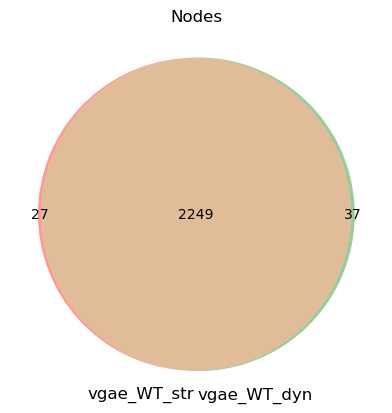

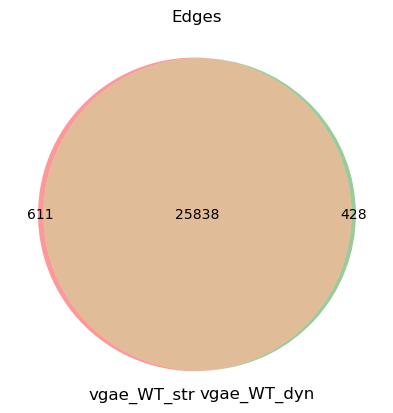

time: 164 ms (started: 2023-06-11 23:46:05 -05:00)


In [30]:
common_nodes_edges = get_common_nodes_edges(list_graphs[0], list_graphs[1],
                                            "{}_{}_{}".format(methods[0], groups[0], options[0]),
                                            "{}_{}_{}".format(methods[1], groups[1], options[1]))

venn2(subsets = (len(common_nodes_edges[1][0]), len(common_nodes_edges[2][0]), len(common_nodes_edges[0][0])),
      set_labels=("{}_{}_{}".format(methods[0], groups[0], options[0]), "{}_{}_{}".format(methods[1], groups[1], options[1])))
plt.title("Nodes")
plt.show()

venn2(subsets = (len(common_nodes_edges[1][1]), len(common_nodes_edges[2][1]), len(common_nodes_edges[0][1])), 
      set_labels=("{}_{}_{}".format(methods[0], groups[0], options[0]), "{}_{}_{}".format(methods[1], groups[1], options[1])))
plt.title("Edges")
plt.show()